# Get output of the GemPy notebook into raster layers for ipyleafelt

In [1]:
import os

# the ipyleaflet stuff
from ipyleaflet import Map, GeoData, basemaps, LayersControl
import geopandas as gpd
import json

# some other stuff
import numpy as np
import matplotlib.pyplot as plt

# raster stuff
import rasterio as rio
from osgeo import gdal
import osr
from pyproj import Proj

List of the horizons

In [2]:
horizons = ['Sables de Fontainebleau',
            'Glaises vertes/marnes',
            'Marnes et Masses',
            'Sables de Monceau',
            'Marno-calcaire de St Ouen',
            'Sables de Beauchamp',
            'Marnes et caillasses',
            'Calcaire grossier',
            'Sables de Cuise',
            'Fausses/Argil Sparnacien',
            'Basement']

In [3]:
xvals = np.load('x-coord.npy')
yvals = np.load('y-coord.npy')
zvals = np.load('z-coord.npy')
lith_block = np.load('lith_block.npy')

In [4]:
zmid = (np.diff(zvals))

In [5]:
def array2raster(newRasterfn, rasterOrigin, pixelWidth, pixelHeight, array, EPSG):
    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    driver.Register()
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(EPSG)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outband.SetNoDataValue(-9999)

def array2rasterflip(newRasterfn, rasterOrigin, pixelWidth, pixelHeight, array, EPSG):
    reversed_arr = array[::-1] # reverse array so the tif looks like the array
    array2raster(newRasterfn, rasterOrigin, pixelWidth, pixelHeight, reversed_arr, EPSG) # convert array to raster

In [6]:
xmin = np.min(xvals)
xmax = np.max(xvals)
xres = len(xvals) - 2
ymin = np.min(yvals)
ymax = np.max(yvals)
yres = len(yvals) - 2

rasterfile = 'test.tif'
rasterOrigin = (xmin, ymin)
pixelWidth = (xmax-xmin)/xres
pixelHeight = (ymax-ymin)/yres
EPSG = 32631

print('Origin = ({}), Width = {}, Height {}'.format(rasterOrigin, pixelWidth, pixelHeight))

Origin = ((427688.6540389154, 5427374.935779131)), Width = 65.2391638195957, Height 68.37963499478995


In [7]:
array2rasterflip(rasterfile, rasterOrigin, pixelWidth, pixelHeight, lith_block[:, :, 10], EPSG)

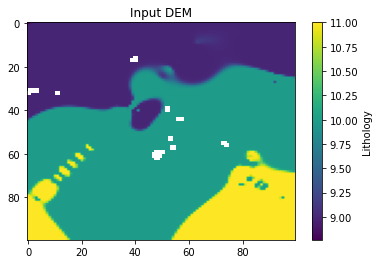

In [8]:
rio_array = rio.open(rasterfile) 
data_array = rio_array.read(1).astype(float)
data_array[data_array < 0] = np.nan
fig=plt.figure()
plt.imshow(data_array, aspect='auto', cmap='viridis')
plt.title('Input DEM')
plt.colorbar(label='Lithology')
plt.show()

In [9]:
myProj = Proj("+proj=utm +zone=31N +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
centreLon, centreLat = myProj(xmin + .5*(xmax-xmin), ymin + .5*(ymax - ymin), inverse=True)
print('UTM centre = ({}, {})'.format(xmin, ymin))
print('centre = ({}, {})'.format(centreLon, centreLat))

UTM centre = (427688.6540389154, 5427374.935779131)
centre = (2.055460350385299, 49.02616282824103)


In [10]:
dem_path = 'testLatLon.tif'
topoDEM = os.getcwd() + '/' + dem_path
dst_crs = 'EPSG:4326'

In [11]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

with rio.open(rasterfile) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rio.open(topoDEM, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [23]:
import gdal2tiles

gdal2tiles.generate_tiles(rasterfile, 'tileset', s_srs='EPSG:32631', zoom='10-14', tile_size=100)

Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Overview Tiles:
0...10...20...30...40...50...60...70...80...90...100


In [24]:
from traitlets import Bool
from ipyleaflet import Map, LocalTileLayer

m = Map(center=(centreLat, centreLon), zoom = 10, basemap=basemaps.Esri.WorldTopoMap)

class CustomLocalLayer(LocalTileLayer):
    tms = Bool(True).tag(sync=True, o=True)

layer = CustomLocalLayer(name='subsurface', tms=True, path="tileset/{z}/{x}/{y}.png")
m.add_layer(layer)

control = LayersControl(position='topright')
m.add_control(control)

m

Map(center=[49.02616282824103, 2.055460350385299], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [25]:
np.shape(data_array)

(100, 100)